# Boro Player Predictions - Current Market Value

## 0. Setup

In [2]:
## standard library
import os
import re

In [3]:
## data wrangling
import numpy as np
import pandas as pd

In [4]:
## visualisation
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

import seaborn as sns
sns.set()

In [147]:
## machine learning
# from sklearn.feature_extraction import DictVectorizer
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample

In [6]:
## project src

In [7]:
## global constants
RANDOM_STATE = 4
TRAIN_SIZE = 0.9

## 1. Problem Definition

* Determine Busines Objectives
* Situation Assessment
* Determine Data Mining Goal
* Produce Project Plan

The aim of this project is to see if we can use data on players at Middlesbrough Football Club to make preditions about the player's and the team's current and future performance.

We have player data from Transfermarkt, ESPN, WhoScored and Fly Me To The Moon (fanzine).

"Performance" could be measured in many different ways: Results on the pitch, market value, fan popularity, churn, ...

## 2. Data Understanding

* Collect Initial Data
* Describe Data
* Explore Data
* Verify Data Quality

The first part of the data we'll look at is some general information on players, including their market value, as taken from Transfermarkt

In [8]:
def extract_season(file_name):
    """
    INPUT:
        file_name - String containing name of the data source file
        
    OUTPUT:
        season_out - String containing the formated label for the season
    """
    
    season_part = file_name.split(".")[0].split("_")[-1]
    season_out = season_part[:2] + "/" + season_part[-2:]
    
    return season_out

# extract_season?

In [9]:
extract_season("tmk_cnt_mbr_all_0910.csv")

'09/10'

In [10]:
def clean_data(source_name):
    """
    INPUT:
        source_name - String containing name of the data source
        
    OUTPUT:
        tmk_df - Dataframe containing the cleaned data
    """

    dir_tmk_cnt = "../data/raw/tmk/tmk_cnt/"
    data_list = []
    for file in os.listdir(dir_tmk_cnt):
        filepath = os.path.join(dir_tmk_cnt, file)
        print(filepath)
        tmp = pd.read_csv(filepath, encoding='latin-1', header=0, 
                          names=["Shirt number", "Position", "Name", "Date of birth", "Nationality",
                                "Height", "Foot", "Joined", "Signed from", "Contract expires",
                                "Market value"])
        tmp["Season"] = extract_season(file)
        data_list.append(tmp)

    tmk_df = pd.concat(data_list, axis=0, sort=False, ignore_index=True)

    tmk_df["Name"].fillna(method="bfill", inplace=True)

    tmk_df["Position"] = tmk_df.Name.shift(-1)
    tmk_df.loc[tmk_df.Position == tmk_df.Name, "Position"] = tmk_df.Name.shift(-2)

    tmk_df.drop(axis=1, columns=["Nationality", "Signed from"], inplace=True)

    tmk_df.dropna(subset=["Market value"], inplace=True)

    tmk_df = tmk_df.replace('-', np.nan)

    tmk_df["Shirt number"] = pd.to_numeric(tmk_df["Shirt number"], downcast='integer')

    tmk_df["Position group"] = None
    tmk_df.loc[(tmk_df.Position.str.upper().str.contains("KEEPER"))
            | (tmk_df.Position.str.upper().str.contains("GOAL")), 
           "Position group"] = "G"
    tmk_df.loc[(tmk_df.Position.str.upper().str.contains("BACK"))
            | (tmk_df.Position.str.upper().str.contains("DEF")), 
           "Position group"] = "D"
    tmk_df.loc[(tmk_df.Position.str.upper().str.contains("MID"))
            | (tmk_df.Position.str.upper().str.contains("MIT"))
            | (tmk_df.Position.str.upper().str.contains("WING")), 
           "Position group"] = "M"
    tmk_df.loc[(tmk_df.Position.str.upper().str.contains("STRIKER"))
            | (tmk_df.Position.str.upper().str.contains("FORW")), 
           "Position group"] = "F"

    tmk_df["Age"] = tmk_df["Date of birth"].str.extract(r".*([0-9]{2})", expand=False).astype("int")

    tmk_df["Date of birth"] = pd.to_datetime(
        tmk_df["Date of birth"].str.extract(r"(.*) \([0-9]{2}\)", expand=False), 
        format="%b %d, %Y")

    tmk_df["Joined"] = pd.to_datetime(tmk_df.Joined, format="%b %d, %Y")

    tmk_df["Contract expires"] = pd.to_datetime(tmk_df["Contract expires"], format="%d.%m.%Y")

    tmk_df["Height"] = (tmk_df["Height"] \
                              .str.strip() \
                              .str.replace(' ', '') \
                              .str.replace(',', '') \
                              .str.replace('m', '') \
                              .replace({'-':np.nan, '':np.nan}) \
                              .astype(float))
    tmk_df.loc[tmk_df.Name.isin(tmk_df[tmk_df.Height.notna()].Name.values)
           & tmk_df.Name.isin(tmk_df[tmk_df.Height.isna()].Name.values), "Height"] = \
    tmk_df.loc[tmk_df.Name.isin(tmk_df[tmk_df.Height.notna()].Name.values)
           & tmk_df.Name.isin(tmk_df[tmk_df.Height.isna()].Name.values)] \
        .sort_values(by=["Name", "Season"]).Height.fillna(method="bfill")
    
    tmk_df.loc[tmk_df.Name.isin(tmk_df[tmk_df.Foot.notna()].Name.values)
           & tmk_df.Name.isin(tmk_df[tmk_df.Foot.isna()].Name.values), "Foot"] = \
    tmk_df.loc[tmk_df.Name.isin(tmk_df[tmk_df.Foot.notna()].Name.values)
           & tmk_df.Name.isin(tmk_df[tmk_df.Foot.isna()].Name.values)] \
        .sort_values(by=["Name", "Season"]).Foot.fillna(method="bfill")

    tmk_df["Market value"] = (tmk_df["Market value"] \
                              .str.strip() \
                              .replace({'-':np.nan}) \
                              .replace(r'[£km]', '', regex=True) \
                              .astype(float) * \
                tmk_df["Market value"].str.extract(r'[\d\.]+([km]+)', expand=False)
                    .fillna(1)
                    .replace(['k','m'], [10**3, 10**6]).astype(int) / 10**6)

    return tmk_df

# clean_data?

In [11]:
tmk_df = clean_data("tmk_cnt")
# tmk_df.info()

../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_0910.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1011.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1112.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1213.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1314.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1415.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1516.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1617.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1718.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1819.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1920.csv


In [12]:
tmk_df.sample(8, random_state=RANDOM_STATE)

,Shirt number,Position,Name,Date of birth,Height,Foot,Joined,Contract expires,Market value,Season,Position group,Age
240,16.0,Centre Forward,Bartholomew Ogbeche,1984-10-01,178.0,both,2011-10-01,NaT,0.450,11/12,F,26
518,7.0,Central Midfield,Grant Leadbitter,1986-01-07,177.0,right,2012-07-01,2017-06-30,1.500,15/16,M,30
611,13.0,Keeper,Tomás Mejías,1989-01-30,195.0,right,2014-07-05,2018-06-30,0.225,17/18,G,29
28,3.0,Left-Back,Andrew Taylor,1986-08-01,178.0,left,2005-07-01,NaT,1.880,09/10,D,22
274,2.0,Right-Back,Justin Hoyte,1984-11-20,180.0,right,2008-08-01,NaT,1.130,12/13,D,27
48,34.0,Defensive Midfield,Isaiah Osbourne,1987-11-05,188.0,right,2009-11-06,NaT,0.375,09/10,M,21
618,4.0,Centre-Back,Daniel Ayala,1990-11-07,190.0,right,2014-01-24,2020-06-30,1.800,17/18,D,27
198,3.0,Left-Back,Joe Bennett,1990-03-28,177.0,left,2008-07-01,NaT,0.188,11/12,D,21


In [13]:
tmk_df.describe(include="all")

,Shirt number,Position,Name,Date of birth,Height,Foot,Joined,Contract expires,Market value,Season,Position group,Age
count,333.000000,364,364,364,356.000000,324,351,169,330.000000,364,364,364.000000
unique,NaN,19,172,169,NaN,3,126,12,NaN,11,4,NaN
top,NaN,Centre Back,Ben Gibson,1993-01-15 00:00:00,NaN,right,2010-07-01 00:00:00,2020-06-30 00:00:00,NaN,09/10,M,NaN
freq,NaN,53,9,9,NaN,201,31,28,NaN,47,134,NaN
first,NaN,NaN,NaN,1973-08-27 00:00:00,NaN,NaN,2000-07-01 00:00:00,2016-05-31 00:00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2000-08-09 00:00:00,NaN,NaN,2020-01-31 00:00:00,2023-06-30 00:00:00,NaN,NaN,NaN,NaN
mean,18.054054,NaN,NaN,NaN,183.286517,NaN,NaN,NaN,1.696327,NaN,NaN,24.826923
std,11.018471,NaN,NaN,NaN,6.028752,NaN,NaN,NaN,1.776398,NaN,NaN,4.696900
min,1.000000,NaN,NaN,NaN,167.000000,NaN,NaN,NaN,0.038000,NaN,NaN,16.000000
25%,8.000000,NaN,NaN,NaN,179.000000,NaN,NaN,NaN,0.375000,NaN,NaN,21.000000


So the data is looking broadly in good shape, but there are a few missing values to consider...

In [14]:
tmk_df.count() / tmk_df.shape[0]

Shirt number        0.914835
Position            1.000000
Name                1.000000
Date of birth       1.000000
Height              0.978022
Foot                0.890110
Joined              0.964286
Contract expires    0.464286
Market value        0.906593
Season              1.000000
Position group      1.000000
Age                 1.000000
dtype: float64

In [15]:
tmk_df.loc[tmk_df.Name.isin(tmk_df[tmk_df.Joined.notna()].Name.values)
       & tmk_df.Name.isin(tmk_df[tmk_df.Joined.isna()].Name.values)].sort_values(by=["Name", "Season"])

,Shirt number,Position,Name,Date of birth,Height,Foot,Joined,Contract expires,Market value,Season,Position group,Age
156,41.0,Left Midfield,Adam Reach,1993-02-03,185.0,left,NaT,NaT,NaN,10/11,M,17
220,32.0,Left Midfield,Adam Reach,1993-02-03,185.0,left,2011-07-01,2019-06-30,NaN,11/12,M,18
300,25.0,Left Midfield,Adam Reach,1993-02-03,185.0,left,2011-07-01,2019-06-30,NaN,12/13,M,19
374,NaN,Left Midfield,Adam Reach,1993-02-03,185.0,left,2011-07-01,2019-06-30,0.188,13/14,M,20
454,20.0,Left Midfield,Adam Reach,1993-02-03,185.0,left,2011-07-01,2019-06-30,0.375,14/15,M,21
26,39.0,Centre Back,Ben Gibson,1993-01-15,185.0,left,NaT,NaT,NaN,09/10,D,16
120,34.0,Centre Back,Ben Gibson,1993-01-15,185.0,left,2010-07-01,2019-06-30,NaN,10/11,D,17
194,34.0,Centre Back,Ben Gibson,1993-01-15,185.0,left,2010-07-01,2019-06-30,NaN,11/12,D,18
266,40.0,Centre Back,Ben Gibson,1993-01-15,185.0,left,2010-07-01,2019-06-30,NaN,12/13,D,19
348,22.0,Centre Back,Ben Gibson,1993-01-15,185.0,left,2010-07-01,2019-06-30,0.188,13/14,D,20


_Possibly_ we could back fill some missing `Joined` dates but this might have some downstream consequences because the date will be at the end of that season. We'll leave them as Nulls for now.

Next we'll look at the distributions of single fields with bar charts for categorical variables and histograms for numeric and date variables

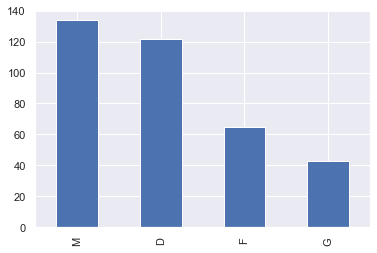

In [16]:
tmk_df["Position group"].value_counts().plot(kind='bar')

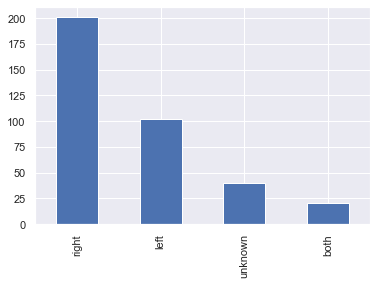

In [17]:
tmk_df.Foot.fillna("unknown").value_counts().plot(kind='bar')

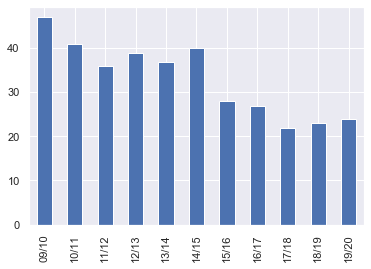

In [18]:
tmk_df.Season.value_counts().sort_index().plot(kind='bar')

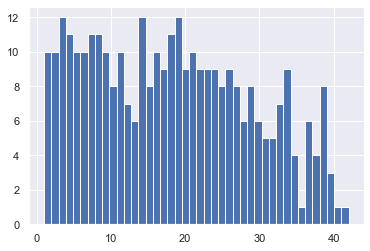

In [19]:
tmk_df["Shirt number"].hist(bins=42)

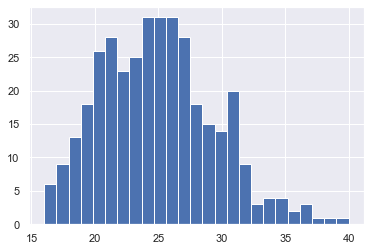

In [20]:
tmk_df["Age"].hist(bins=25)

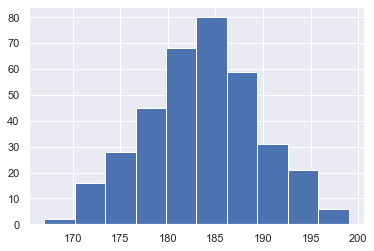

In [21]:
tmk_df["Height"].hist()

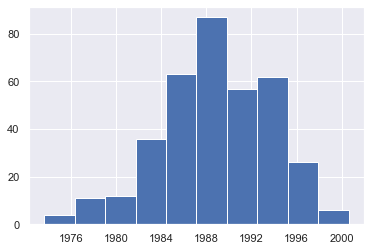

In [22]:
tmk_df["Date of birth"].hist()

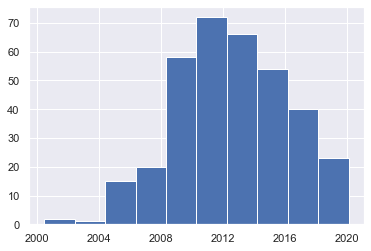

In [23]:
tmk_df["Joined"].hist()

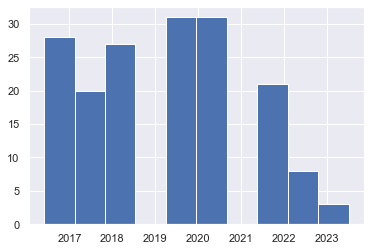

In [24]:
tmk_df["Contract expires"].hist()

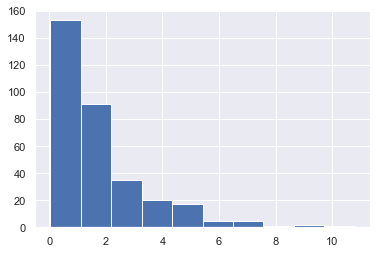

In [25]:
tmk_df["Market value"].hist()

We can explore simple relationships between variables using pairplots and histogram facet grids

C:\Users\adeacon\AppData\Local\Continuum\miniconda3\envs\projects\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\adeacon\AppData\Local\Continuum\miniconda3\envs\projects\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


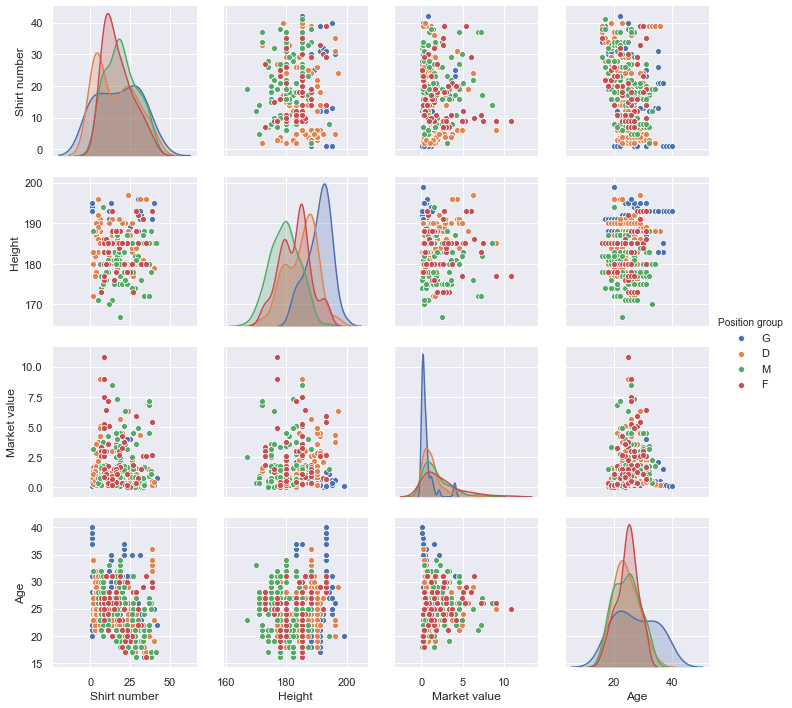

In [26]:
sns.pairplot(tmk_df, hue="Position group")

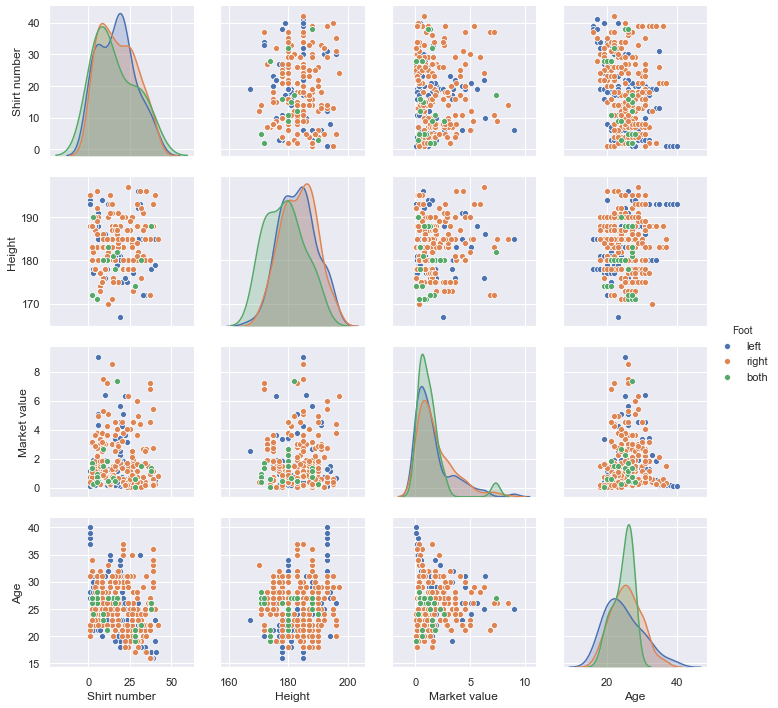

In [27]:
sns.pairplot(tmk_df, hue="Foot")

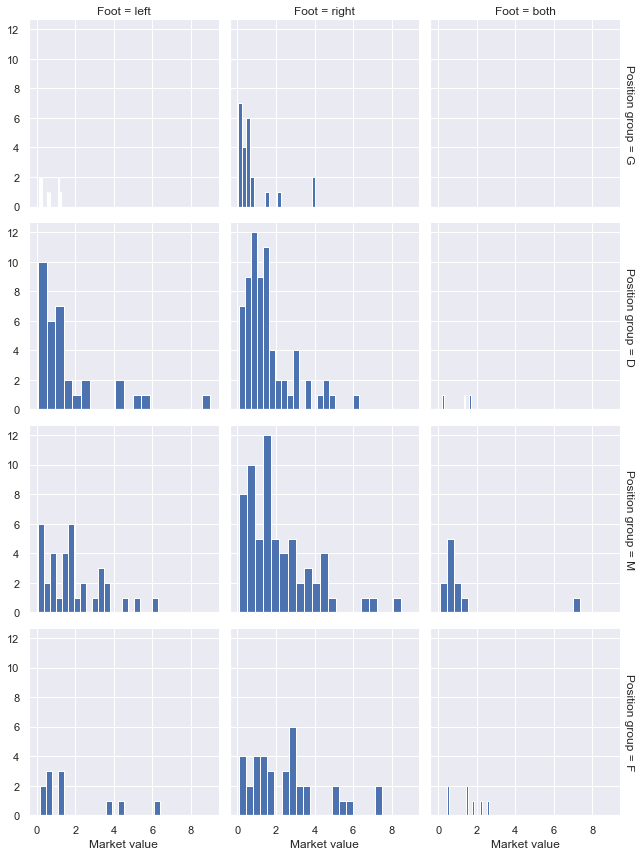

In [28]:
grid = sns.FacetGrid(tmk_df, row="Position group", col="Foot", margin_titles=True)
grid.map(plt.hist, "Market value", bins=20)

## 3. Data Preperation

* Select Data
* Clean Data
* Construct Data
* Integrate Data
* Format Data

In [29]:
df = tmk_df.copy()
df.shape

(364, 12)

In [30]:
df["Player key"] = df.Name + " (" + df.Season + ")"
df.set_index(df["Player key"], drop=True, inplace=True, verify_integrity=True)
df.drop(columns=["Player key"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 364 entries, Brad Jones (09/10) to Rudy Gestede (19/20)
Data columns (total 12 columns):
Shirt number        333 non-null float64
Position            364 non-null object
Name                364 non-null object
Date of birth       364 non-null datetime64[ns]
Height              356 non-null float64
Foot                324 non-null object
Joined              351 non-null datetime64[ns]
Contract expires    169 non-null datetime64[ns]
Market value        330 non-null float64
Season              364 non-null object
Position group      364 non-null object
Age                 364 non-null int32
dtypes: datetime64[ns](3), float64(3), int32(1), object(5)
memory usage: 35.5+ KB


We can derive some new numeric features to express relationships between dates

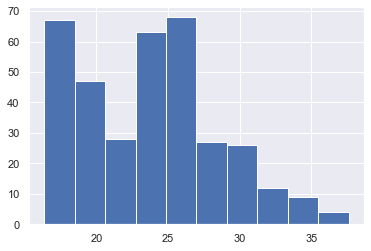

In [31]:
df["Age when joined"] = (df["Joined"] - df["Date of birth"])/ np.timedelta64(1, 'Y')
df["Age when joined"].hist()

Most players join in their teens or mid-twenties.

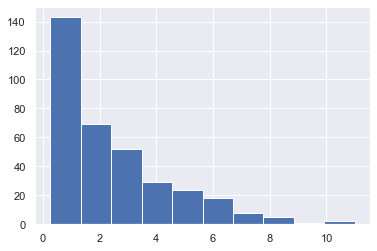

In [32]:
df["Years in team"] = (pd.to_datetime("1st July 20"+df.Season.str[-2:]) - df["Joined"])/ np.timedelta64(1, 'Y')
df["Years in team"].hist()

I'm going to leave out `Shirt number`, `Position`, `Name`, `Date of birth`, `Joined`, `Season` and `Contract expires` from the model for now. `Contract expires` is populated in less than half of records. The others can be discarded for simplicity of model.

In [33]:
df.drop(columns=["Shirt number", "Position", "Name", "Date of birth", "Joined", "Season", "Contract expires"], inplace=True)
df.shape

(364, 7)

`Foot` and `Position group` will be one-hot encoded 

In [34]:
for var in ["Foot", "Position group"]:
    df = pd.concat(
        [
            df.drop(var, axis=1),
            pd.get_dummies(
                df[var], prefix=var, prefix_sep="=", drop_first=False
            ),
        ],
        axis=1,
    )

# df.describe()
df.shape

(364, 12)

In [35]:
df.sample(5, random_state=RANDOM_STATE)

,Height,Market value,Age,Age when joined,Years in team,Foot=both,Foot=left,Foot=right,Position group=D,Position group=F,Position group=G,Position group=M
Player key,,,,,,,,,,,,
Bartholomew Ogbeche (11/12),178.0,0.450,26,26.998501,0.750187,1,0,0,0,1,0,0
Grant Leadbitter (15/16),177.0,1.500,30,26.481037,4.000082,0,0,1,0,0,0,1
Tomás Mejías (17/18),195.0,0.225,29,25.426942,3.989131,0,0,1,0,0,1,0
Andrew Taylor (09/10),178.0,1.880,22,18.916200,4.999418,0,1,0,1,0,0,0
Justin Hoyte (12/13),180.0,1.130,27,23.696585,4.914543,0,0,1,1,0,0,0


In [36]:
df.describe()

,Height,Market value,Age,Age when joined,Years in team,Foot=both,Foot=left,Foot=right,Position group=D,Position group=F,Position group=G,Position group=M
count,356.000000,330.000000,364.000000,351.000000,351.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000
mean,183.286517,1.696327,24.826923,23.871039,2.447119,0.057692,0.280220,0.552198,0.335165,0.178571,0.118132,0.368132
std,6.028752,1.776398,4.696900,4.733915,2.005552,0.233482,0.449725,0.497952,0.472698,0.383520,0.323208,0.482961
min,167.000000,0.038000,16.000000,16.356256,0.265577,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,179.000000,0.375000,21.000000,19.409023,0.913092,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,183.000000,1.130000,25.000000,23.907404,1.960341,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,188.000000,2.250000,28.000000,26.554960,3.422384,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,199.000000,10.800000,40.000000,37.607891,10.998172,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [37]:
df[df.Height.isna() | df["Age when joined"].isna() | df["Years in team"].isna()].shape

(17, 12)

~~Discard a handful of rows which don't have `Height` and/or `Age when joined` and/or `Years in team`~~

In [38]:
# df = df[df.Height.notna() & df["Age when joined"].notna() & df["Years in team"].notna()]
# df.shape

In [39]:
# df.describe()

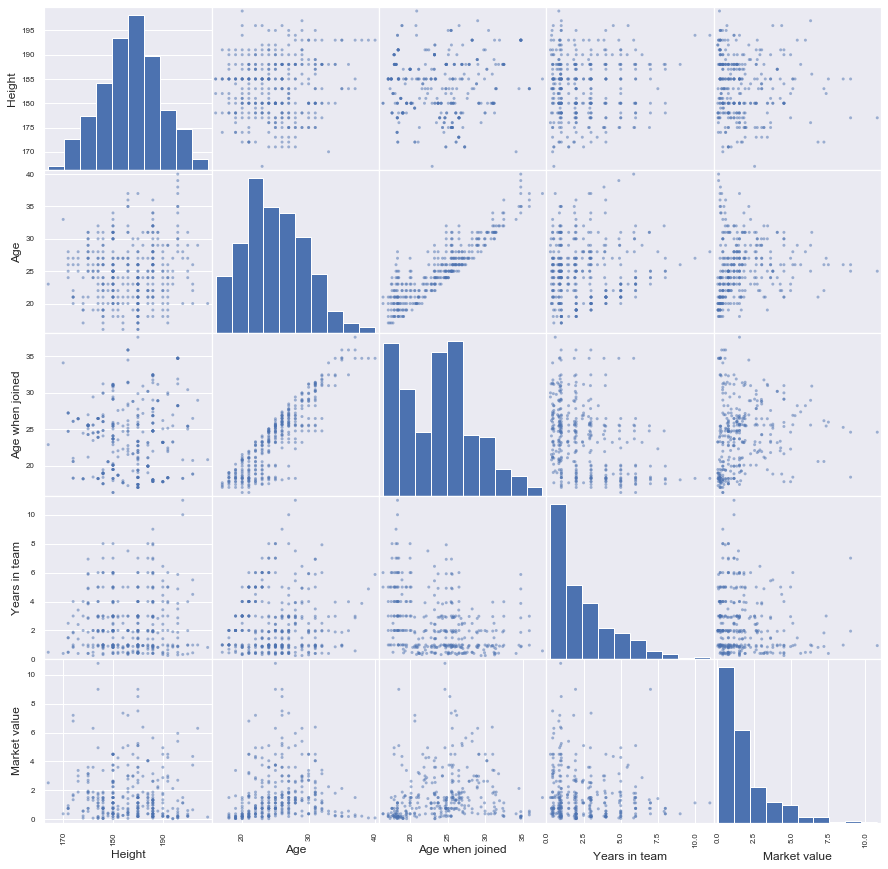

In [40]:
pd.plotting.scatter_matrix(df[["Height", "Age", "Age when joined", "Years in team", "Market value"]], figsize=(15,15));

In [41]:
df.columns

Index(['Height', 'Market value', 'Age', 'Age when joined', 'Years in team',
       'Foot=both', 'Foot=left', 'Foot=right', 'Position group=D',
       'Position group=F', 'Position group=G', 'Position group=M'],
      dtype='object')

## 4. Modelling

* Select Modelling Technique
* Generate Test Design
* Build Model
* Assess Model

Specify our features matrix and target vector. Split test and train sets. Also the handful of records without a `Market value` can be held back and _potentially_ assigned values using the model.

In [65]:
feature_names = ['Height', 'Age', 'Age when joined', 'Years in team', 'Foot=both',
       'Foot=left', 'Foot=right', 'Position group=D', 'Position group=F',
       'Position group=G', 'Position group=M']
feature_names

['Height',
 'Age',
 'Age when joined',
 'Years in team',
 'Foot=both',
 'Foot=left',
 'Foot=right',
 'Position group=D',
 'Position group=F',
 'Position group=G',
 'Position group=M']

In [117]:
X = df[df.notna().all(axis=1)][feature_names]
y = df[df.notna().all(axis=1)]["Market value"]

X.shape, y.shape

((328, 11), (328,))

In [118]:
X.shape[0] / (X.shape[1] ** 2)

2.7107438016528924

In [119]:
X.columns

Index(['Height', 'Age', 'Age when joined', 'Years in team', 'Foot=both',
       'Foot=left', 'Foot=right', 'Position group=D', 'Position group=F',
       'Position group=G', 'Position group=M'],
      dtype='object')

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

In [126]:
model = LinearRegression() #normalize=True)
# model = LinearRegression(fit_intercept=False)
model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [128]:
param_grid = {"fit_intercept": [True, False],
             "normalize": [True, False],}
param_grid

{'fit_intercept': [True, False], 'normalize': [True, False]}

In [132]:
grid = GridSearchCV(model, param_grid, cv=3)
grid

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'fit_intercept': [True, False], 'normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [133]:
grid.fit(X, y)

C:\Users\adeacon\AppData\Local\Continuum\miniconda3\envs\projects\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'fit_intercept': [True, False], 'normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [134]:
grid.best_params_

{'fit_intercept': True, 'normalize': False}

In [174]:
model = grid.best_estimator_
model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [175]:
for scoring in ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']:
    results = cross_val_score(model, X, y, cv=3, scoring=scoring)
    print("{0}: {1} ({2})".format(scoring, results.mean(), results.std()))

neg_mean_absolute_error: -1.418035760377796 (0.38218203534263817)
neg_mean_squared_error: -4.013017967454331 (2.7067258931253324)
r2: -0.8341952236199844 (0.594064688615392)


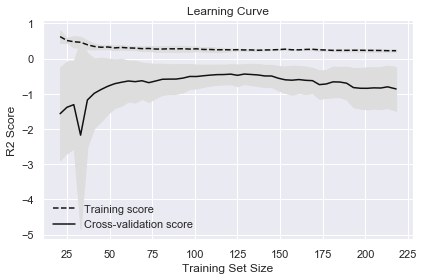

In [136]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(model, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=3,
                                                        # Evaluation metric
#                                                         scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.1, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("R2 Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, train_size=120)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

C:\Users\adeacon\AppData\Local\Continuum\miniconda3\envs\projects\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


((120, 11), (208, 11), (120,), (208,))

In [201]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [202]:
model.score(X_train, y_train)

0.24416717797737342

In [43]:
# Model selection - LinearRegression, Lasso, ElasticNet, RidgeRegression, SVR(kernel="linear")
# Learning curves 
# Test/train split and Cross validation
# Validation (Grid Search)
# Pipeline
# Feature scaling

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression

## 5. Evaluation

* Evaluate Results
* Review Process
* Determine Next Steps

In [ ]:
# MSE, RMSE
# MAE
# R squared
# https://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/


In [203]:
model.score(X_test, y_test)

0.14475111674269936

In [204]:
model.coef_

array([-0.00596635,  1.56425439, -1.53018139, -1.59981291,  0.70595384,
        0.65465149,  0.77631954,  0.08138335,  0.7361457 , -1.17994777,
        0.36241871])

In [205]:
model.intercept_

3.1313627066691945

In [206]:
params = pd.Series(model.coef_, index=X.columns)
params

Height             -0.005966
Age                 1.564254
Age when joined    -1.530181
Years in team      -1.599813
Foot=both           0.705954
Foot=left           0.654651
Foot=right          0.776320
Position group=D    0.081383
Position group=F    0.736146
Position group=G   -1.179948
Position group=M    0.362419
dtype: float64

In [207]:
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_ for i in range(1000)], 0)
err

array([0.02045882, 0.20572599, 0.20842991, 0.21365762, 0.58366259,
       0.47310029, 0.47934444, 0.13283397, 0.20990339, 0.19277753,
       0.16496983])

In [208]:
pd.DataFrame({"effect": params.round(2), "error": err.round(2)})

,effect,error
Height,-0.01,0.02
Age,1.56,0.21
Age when joined,-1.53,0.21
Years in team,-1.60,0.21
Foot=both,0.71,0.58
Foot=left,0.65,0.47
Foot=right,0.78,0.48
Position group=D,0.08,0.13
Position group=F,0.74,0.21
Position group=G,-1.18,0.19


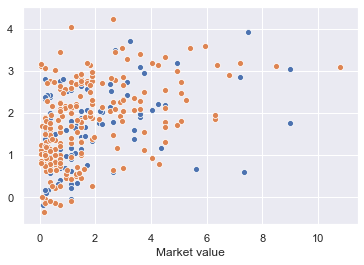

In [209]:
sns.scatterplot(y_train, model.predict(X_train))
sns.scatterplot(y_test, model.predict(X_test))

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

In [75]:
# def PolynomialRegression(degree=2, **kwargs):
#     return make_pipeline(PolynomialFeatures(degree),
#                         LinearRegression(**kwargs))

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html?highlight=validation_curve#sklearn.model_selection.validation_curve

In [76]:
# degree = np.arange(0,10)
# train_score, val_score = validation_curve(PolynomialRegression(), X, y,
#                                          'polynomialfeatures__degree',
#                                          degree, cv=5)

# plt.plot(degree, np.median(train_score, 1), color="blue", label="training score")
# plt.plot(degree, np.median(val_score, 1), color="red", label="validation score")
# plt.legend(loc="best")
# plt.ylim(0, 1)
# plt.xlabel("degree")
# plt.ylabel("score");

In [77]:
# # Create range of values for parameter
# param_range = np.arange(1, 250, 2)

# # Calculate accuracy on training and test set using range of parameter values
# train_scores, test_scores = validation_curve(RandomForestClassifier(), 
#                                              X, 
#                                              y, 
#                                              param_name="n_estimators", 
#                                              param_range=param_range,
#                                              cv=3, 
#                                              scoring="accuracy", 
#                                              n_jobs=-1)


# # Calculate mean and standard deviation for training set scores
# train_mean = np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)

# # Calculate mean and standard deviation for test set scores
# test_mean = np.mean(test_scores, axis=1)
# test_std = np.std(test_scores, axis=1)

# # Plot mean accuracy scores for training and test sets
# plt.plot(param_range, train_mean, label="Training score", color="black")
# plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# # Plot accurancy bands for training and test sets
# plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
# plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# # Create plot
# plt.title("Validation Curve With Random Forest")
# plt.xlabel("Number Of Trees")
# plt.ylabel("Accuracy Score")
# plt.tight_layout()
# plt.legend(loc="best")
# plt.show()

In [78]:
# train_score

In [79]:
# val_score

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html

In [80]:
# fig, ax = plt.subplots(1, 2, figsize=(16, 6))
# fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

# for i, degree in enumerate([2, 4]):
#     N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
#                                          X, y, cv=5,
#                                          train_sizes=np.linspace(0.3, 1, 25))

#     ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
#     ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
#     ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
#                  color='gray', linestyle='dashed')

#     ax[i].set_ylim(-0.1, 1.1)
#     ax[i].set_xlim(N[0], N[-1])
#     ax[i].set_xlabel('training size')
#     ax[i].set_ylabel('score')
#     ax[i].set_title('degree = {0}'.format(degree), size=14)
#     ax[i].legend(loc='best')

## 6. Deployment

* Plan Deployment
* Plan Monitoring and Maintenance
* Produce Final Report
* Review Project

In [ ]:
# Fill missing values
# Any conclusions on predictions

In [160]:
df_unseen = df[df["Market value"].isna()]
df_unseen.shape

(34, 12)

In [210]:
unseen_predictions = pd.Series(model.predict(df_unseen[feature_names].dropna()), 
          index=df_unseen[feature_names].dropna().index)
unseen_predictions

Player key
Jay O'Shea (09/10)           1.325046
Ben Gibson (10/11)           0.933638
Richard Smallwood (10/11)    1.075825
Luke Williams (10/11)        2.472767
Connor Ripley (11/12)       -0.037862
Ben Gibson (11/12)           0.883883
Cameron Park (11/12)         0.863075
Adam Reach (11/12)           1.482308
Alex Nimely (11/12)          3.049585
Christian Burgess (12/13)    0.950748
Ben Gibson (12/13)           0.837262
Adam Reach (12/13)           1.435687
Bryn Morris (13/14)          1.431125
Ryan Brobbel (13/14)         1.500031
Bradley Halliday (14/15)     0.636304
Ryan Fredericks (14/15)      1.008700
Milos Veljkovic (14/15)      1.415445
Ryan Brobbel (14/15)         1.453410
Bradley Fewster (14/15)      2.090427
dtype: float64

In [211]:
pd.concat([df_unseen[feature_names].dropna(), unseen_predictions], axis=1)

,Height,Age,Age when joined,Years in team,Foot=both,Foot=left,Foot=right,Position group=D,Position group=F,Position group=G,Position group=M,0
Player key,,,,,,,,,,,,
Jay O'Shea (09/10),183.0,20,21.555542,0.334025,0,0,1,0,0,0,1,1.325046
Ben Gibson (10/11),185.0,17,17.456895,0.999336,0,1,0,1,0,0,0,0.933638
Richard Smallwood (10/11),180.0,19,19.504850,0.999336,0,0,0,0,0,0,1,1.075825
Luke Williams (10/11),185.0,17,17.054423,0.999336,0,0,0,0,1,0,0,2.472767
Connor Ripley (11/12),191.0,18,18.376832,1.002074,0,0,0,0,0,1,0,-0.037862
Ben Gibson (11/12),185.0,18,17.456895,2.001410,0,1,0,1,0,0,0,0.883883
Cameron Park (11/12),178.0,18,18.984647,1.002074,0,1,0,0,0,0,1,0.863075
Adam Reach (11/12),185.0,18,18.404211,1.002074,0,1,0,0,0,0,1,1.482308
Alex Nimely (11/12),180.0,20,20.309794,0.832324,0,0,1,0,1,0,0,3.049585


In [183]:
!jupyter nbconvert --to html 1.1-boro-current-market-value.ipynb

[NbConvertApp] Converting notebook 1.1-boro-current-market-value.ipynb to html
[NbConvertApp] Writing 1300033 bytes to 1.1-boro-current-market-value.html


In [184]:
!jupyter nbconvert --to python 1.1-boro-current-market-value.ipynb

[NbConvertApp] Converting notebook 1.1-boro-current-market-value.ipynb to python
[NbConvertApp] Writing 19399 bytes to 1.1-boro-current-market-value.py


In [182]:
# !jupyter nbconvert --to markdown 1.1-boro-current-market-value.ipynb

[NbConvertApp] Converting notebook 1.1-boro-current-market-value.ipynb to markdown
[NbConvertApp] Support files will be in 1.1-boro-current-market-value_files\
[NbConvertApp] Making directory 1.1-boro-current-market-value_files
[NbConvertApp] Making directory 1.1-boro-current-market-value_files
[NbConvertApp] Making directory 1.1-boro-current-market-value_files
[NbConvertApp] Making directory 1.1-boro-current-market-value_files
[NbConvertApp] Making directory 1.1-boro-current-market-value_files
[NbConvertApp] Making directory 1.1-boro-current-market-value_files
[NbConvertApp] Making directory 1.1-boro-current-market-value_files
[NbConvertApp] Making directory 1.1-boro-current-market-value_files
[NbConvertApp] Making directory 1.1-boro-current-market-value_files
[NbConvertApp] Making directory 1.1-boro-current-market-value_files
[NbConvertApp] Making directory 1.1-boro-current-market-value_files
[NbConvertApp] Making directory 1.1-boro-current-market-value_files
[NbConvertApp] Making di